In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import matplotlib
import sklearn
print("package版本信息：")
print("numpy:      ", np.__version__)
print("pandas:     ", pd.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)
print("seaborn:    ", sns.__version__)

package版本信息：
numpy:       1.23.3
pandas:      1.4.4
matplotlib:  3.5.3
sklearn:     1.1.2
seaborn:     0.12.1


In [2]:
import warnings
warnings.filterwarnings("ignore")

# XGB简介

## 使用流程

1. 使用`xgb.DMatrix()`类导入数据
2. 使用字典设置参数
3. 调用`xgb.train()`函数训练模型
4. 预测
5. 绘制相关的树

```python
import xgboost as xgb

# 1
dtrain = xgb.DMatrix('train.svm.txt')
dtest = xgb.DMatrix('test.svm.buffer')

# 2
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

evallist = [(dtest, 'eval'), (dtrain, 'train')]

# 3
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

# 4
data = np.random.rand(7, 10)
dtest = xgb.DMatrix(data)
ypred = bst.predict(dtest)

# 5
xgb.plot_importance(bst)
```

## 参数介绍

XGBoost主要有三种类型的参数，参考官方文档 [XGBoost Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)

+ **General parameters**，选择使用哪一类的booster相关的参数，也就是选择基分类器，比如树模型或者线性模型
+ **Booster parameters** ，对应`Booster`的参数
+ **Learning task parameters** ，控制具体训练任务的参数

<font color='red'>这些参数在配合下面的 `xgboost.train()` 函数使用时，需要放在 `param` 参数的字典里面。</font>

### General parameters

用得上的就下面几个：

`booster`：使用的基本学习器，可选值如下：
  + `gbtree`，树模型，默认值
  + `dart`，带dropout的树模型
  + `gblinear`，线性模型
  

`verbosity`：控制打印的信息级别，有如下值
  + 0——silent，默认
  + 1——warning
  + 2——info
  + 3——debug


`nthread`：线程数，默认为可使用的最大值

### Tree Booster 参数

常用的配置参数如下，括号中是sklearn接口的参数名.

- `eta` (alias: `learning_rate`)  
  控制学习速率，也就是每棵树前的系数，default=0.3；   
  和GBDT不一样，XGB里学习速率这个参数一般不进行调整，因为它的影响不好判断。
- `max_depth`  
  树的最大深度，default=6
- `gamma` (alias: `min_split_loss`)  
  每次分裂的最小增益，**对应于损失函数中叶子节点个数的正则项系数 $\gamma$，** default=0
- `lambda` (alias: `reg_lambda`)  
  L2正则项的参数，**对应于损失函数中叶子节点值的正则项系数 $\lambda$，** default=1
- `alpha` (alias: `reg_alpha`)  
  L1正则项的参数，**default=0，不启用** —— <font color='red'>这个通常不进行调整</font>
  
- `subsample`   
  采样比例，取值为(0,1]，default=1，**不能设置为0**

- `sample_method` 采样方式，可选值如下：
  - `uniform`：均匀采样，**默认值**
  - `gradient_based`：这个比较复杂 
  
  这个参数一般不需要动。

- 列采样参数：`colsample_bytree`, `colsample_bylevel`, `colsample_bynode`   
  指定采样的列的占比，范围均为(0, 1]，default=1
  + `colsample_bytree`：构建每棵 tree 时的列采样比例，每棵树的构建过程只进行一次采样。
  + `colsample_bylevel`：构建每个 level 时的列采样比例，每一层的构建过程进行一次采样
  + `colsample_bynode` 构建每个 node 时的列采样比例，每个节点的构建过程进行一次采样
  
  上述的3个参数效果是累计的，比如`{'colsample_bytree':0.5, 'colsample_bylevel':0.5, 'colsample_bynode':0.5}`，假设特征数=64，此时每次split的采样特征数为：$64 \times 0.5 \times 0.5 \times 0.5=8$.

+ `tree_method`
  **用于控制树的生成算法**
  + `auto`：**默认值**，使用启发式的方法，选择最快的生成方式
    + 对于小数据集，使用`exact`
    + 对于大数据集，使用近似算法`approx`
  + `exact`: **Enumerates all split candidates**——枚举所有的候选分割点.
  + `approx`: Approximate greedy algorithm using quantile sketch and gradient histogram——使用近似的分位数概要算法.
  + `hist`: Faster histogram optimized approximate greedy algorithm——使用快速直方图算法.
  + `gpu_hist`: GPU implementation of `hist` algorithm.
  
- `min_child_weight`  
  每个子节点的最小weight之和，取值为 $[0, \inf]$
  
- `scale_pos_weight`  
  控制正负样本的权重，通常用于不平衡样本，default=1.  
  通常为 sum(neg)/sum(pos).
  
- `grow_policy`  树的生长方式，广度优先或者深度优先.   
  只支持 `tree_method`={`hist`, `approx`, `gpu_hist`}.
  - `depthwise`
  - `lossguide`   
    ...
  
- `max_delta_step`  
  default=0，——**这个参数通常不需要动**

### Dart Booster 参数

DART 除了上述的 Tree Booster 参数，还有如下参数.

+ `sample_type`：树的采样方式
  + `uniform`
  + `weighted`，根据树的weight进行采样  
  ...

+ `rate_drop`  
  drop 比例，default=0.0，取值为 $[0, 1.0]$

### Linear Booster 参数

### Learning Task 参数

**`objective`**: 设置目标函数
- **`reg:squarederror`**: 回归问题-平方损失函数，默认值.
- `reg:squaredlogerror`: 回归问题-对数平方损失函数.   
   $\frac{1}{2}[log(pred+1)−log(label+1)]^2$,要求所有的输入label >= -1.
- `reg:logistic`: 分类问题-logistic regression
- **`binary:logistic`**: 二分类问题-logistic regression for **binary** classification, output probability——**输出值直接是概率**
- `binary:logitraw`: 二分类问题-logistic regression for **binary** classification, output score before logistic transformation——**输出值是对数几率，不是概率**
- `binary:hinge`: hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.
- `multi:softmax`: 多分类问题
- `multi:softprob`: 多分类问题

**`eval_metric`：list of str**, 在**验证集**上进行评估的指标，而不是用于优化的指标，可以采用列表的形式传入多个评估指标.   
根据`objective`不同，有默认的评估指标，它用于**配合`xgb.train()`函数中的`eval`参数一起使用**.
- `rmse`: 均方误差，回归问题的默认指标
- `rmsle`: root mean square log error. Default metric of `reg:squaredlogerror` objective.
   适用于有异常值的数据。
- `mae`:
- `logloss`: negative log-likelihood
- `error`: 二分类的误差率. 计算方式为 `#(wrong cases)/#(all cases)`. 分类问题的默认指标。
- `error@t`: 指定二分类的误差率的计算阈值为`k`
- `merror`: 多分类误差率. 计算方式为 `#(wrong cases)/#(all cases)`.
- `mlogloss`: Multiclass logloss
- `auc`: 
- `aucpr`: Area under the PR curve

`base_score`: **用于初始化树的值，默认为0.5**

`seed`：随机数种子值，defalut=0.

----

# XGB接口

注意xgb的版本，0.90版本的XGB是没有`'objective': 'reg:squaredlogerror'`这个参数的

In [13]:
import xgboost as xgb
print('xgboost.version: ', xgb.__version__)

xgboost.version:  1.7.1


## 数据集

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing  # 这是一个在线数据集，是一个回归问题

In [4]:
housing_data = fetch_california_housing(as_frame=True)
housing_data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [5]:
print(housing_data.data.__class__)
housing_data.data.shape

<class 'pandas.core.frame.DataFrame'>


(20640, 8)

In [7]:
print('feature_names: ', housing_data.feature_names)
print('target_names: ', housing_data.target_names)

feature_names:  ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
target_names:  ['MedHouseVal']


In [8]:
print(housing_data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [9]:
housing_data.data.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(housing_data.data, housing_data.target, test_size=0.3, random_state=29)
print(Xtrain.shape)
print(Xtest.shape)

(14448, 8)
(6192, 8)


## 数据载入

`class xgboost.DMatrix()`类.

初始化参数：
+ `data` - 要传入的数据，自变量
+ `label` - 数据label，也就是目标变量
+ `weight` - 样本权重
+ `features_name` - list of str，特征名称
+ `feature_types` - list of str, 特征类型
+ `feature_weights` - 特征权重

属性：
+ `feature_names`
+ `feature_types`

方法：
+ `num_col()`
+ `num_row()`
+ `get_weight()`
+ `get_label()`

In [14]:
dtrain = xgb.DMatrix(data=Xtrain, label=ytrain, feature_names=Xtrain.columns)
dtest = xgb.DMatrix(data=Xtest, label=ytest, feature_names=Xtest.columns)

In [15]:
dtrain.num_col()

8

In [16]:
dtrain.num_row()

14448

In [17]:
print(dtrain.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


## 配置参数  

这里需要配置的参数就是 *参数介绍* 小节里的参数，下面的参数都是默认值，只不过显式写出来了。

In [21]:
# 这个params字段里配置的是 Booster 类的参数
params = {
    'booster':'gbtree',  #基分类器
    'objective': 'reg:squarederror', #目标函数
    # 'objective': 'reg:squaredlogerror',
    'eta': 0.3,  #学习速率
    'gamma': 0,  #分裂的最小增益
    'max_depth': 6,  #树的最大深度
    'lambda': 1,  #L2正则项系数
    'alpha': 0,  # L1正则项系数
    'subsample': 1,  #boostrap时的采样比例
    'tree_method': 'auto',  # 树的生成方式
    'base_score': 0.5,  # 生成第一棵树时的初始值
    'eval_metric': ['rmse','mae']  # 在 验证集 上进行评估的指标，可以选择多个
}

# booster的个数
num_round = 10

# 用于训练时查看验证集上效果的 evals (list of pairs (DMatrix, string)) 
watch_list = [(dtrain, 'val_train'), (dtest, 'val_test')]

## 训练模型

```python
xgboost.train(params, dtrain, num_boost_round=10, *, evals=None, ...)
```

+ `params`：booster参数，字典
+ `dtrain`：训练数据，`DMatrix`对象
+ `num_boost_round`：boosting的数量
+ `evals`：List of `(DMatrix, str)`的形式，validation set 和对应的标识名称，其中标识名称里尽量不要有特殊字符（比如`-`之类的）
+ `evals_result`：传入一个空的dict，用于记录验证集上的结果.
+ `obj`：**自定义目标函数**
+ `feval`/`custom_metric`：**自定义的metric函数**，从1.6.0版本开始，使用custom_metric参数

返回值为一个`Booster`类对象。


`evals`参数要配合`params`里设置的`eval_metric`一起使用，训练过程中会输出验证集上的结果，会显示`num_round`行记录，每行有$eval\_metric*watch\_list$的记录。     
比如 `evals=[(d1, 'val_name_1'), (d2, 'val_name_2')]`，`evals=['rmse', 'mae']`，相当于在两个验证集上分别使用两个指标，每一行输出 2x2=4 个指标，指标的名称就是`evals`的验证集label+`evals`里的指标名。  
此外，`evals_result`里传入的字典里，返回结果字段结构为：`{验证集名称: {指标名称: [指标结果]}}`。


In [22]:
evals_result = {}
bst = xgb.train(
    params=params, dtrain=dtrain, num_boost_round=num_round, 
    evals=watch_list, evals_result=evals_result
)

[0]	val_train-rmse:1.44435	val_train-mae:1.11335	val_test-rmse:1.44693	val_test-mae:1.11732
[1]	val_train-rmse:1.10565	val_train-mae:0.81661	val_test-rmse:1.10772	val_test-mae:0.82362
[2]	val_train-rmse:0.88097	val_train-mae:0.62720	val_test-rmse:0.88730	val_test-mae:0.63694
[3]	val_train-rmse:0.73986	val_train-mae:0.51422	val_test-rmse:0.75214	val_test-mae:0.52592
[4]	val_train-rmse:0.64561	val_train-mae:0.44274	val_test-rmse:0.66511	val_test-mae:0.45755
[5]	val_train-rmse:0.59143	val_train-mae:0.40497	val_test-rmse:0.61825	val_test-mae:0.42407
[6]	val_train-rmse:0.55445	val_train-mae:0.37861	val_test-rmse:0.58601	val_test-mae:0.40065
[7]	val_train-rmse:0.52890	val_train-mae:0.36251	val_test-rmse:0.56520	val_test-mae:0.38698
[8]	val_train-rmse:0.50881	val_train-mae:0.34939	val_test-rmse:0.55051	val_test-mae:0.37737
[9]	val_train-rmse:0.48914	val_train-mae:0.33597	val_test-rmse:0.53480	val_test-mae:0.36602


In [28]:
evals_result

{'val_train': OrderedDict([('rmse',
               [1.4443470153307385,
                1.105647856141013,
                0.8809698177159757,
                0.7398561182441694,
                0.6456134577703455,
                0.5914314718382635,
                0.5544491765513351,
                0.5288996060729827,
                0.50880861299035,
                0.48914463685917453]),
              ('mae',
               [1.113350265738807,
                0.8166059184930847,
                0.6272017384548223,
                0.5142156756890408,
                0.44273785064832316,
                0.4049692947070959,
                0.37861100789097657,
                0.36250761703712864,
                0.34938666354431663,
                0.3359672475300919])]),
 'val_test': OrderedDict([('rmse',
               [1.446931460784928,
                1.107719813737852,
                0.8872957259964922,
                0.7521354592492671,
                0.6651120388770201,
  

## 查看模型参数

`class xgboost.Booster(params=None, cache=None, model_file=None)`类。  
**一般它是由`train()`函数返回的，而不是由自己手动实例化**。

常用属性如下：
+ `feature_names`
+ `feature_types`

常用的用于探究模型结构的方法如下：

+ `attributes()`：返回所有的属性。

+ `num_features()`：返回特征个数。

+ `num_boosted_rounds()`：返回booster数量。

+ `get_fscore(fmap='')`：获取每个特征的重要性度量。


+ `get_score(fmap='', importance_type='weight')`：获取每个特征的重要性度量  
 importance_type可选值为:
  + `weight`：所有树中该特征被用于split的总数
  + `gain`
  + `cover`
  + `total_gain`
  + `total_cover`  
  ..

+ `get_split_value_histogram(feature, fmap='', bins=None, as_pandas=True)`  
 获取某个特征的split直方图


In [29]:
bst.attributes()

{'best_iteration': '9', 'best_ntree_limit': '10'}

In [30]:
# 获取模型里各个特征的feature importance
bst.get_fscore()

{'MedInc': 82.0,
 'HouseAge': 54.0,
 'AveRooms': 46.0,
 'AveBedrms': 51.0,
 'Population': 26.0,
 'AveOccup': 74.0,
 'Latitude': 128.0,
 'Longitude': 149.0}

In [31]:
# 指定获取模型里各个特征的某种指标
bst.get_score(importance_type='weight')

{'MedInc': 82.0,
 'HouseAge': 54.0,
 'AveRooms': 46.0,
 'AveBedrms': 51.0,
 'Population': 26.0,
 'AveOccup': 74.0,
 'Latitude': 128.0,
 'Longitude': 149.0}

In [32]:
bst.get_score(importance_type='gain')

{'MedInc': 224.84934997558594,
 'HouseAge': 21.987112045288086,
 'AveRooms': 16.908733367919922,
 'AveBedrms': 4.840752601623535,
 'Population': 4.660333156585693,
 'AveOccup': 58.328208923339844,
 'Latitude': 19.682804107666016,
 'Longitude': 20.22434425354004}

In [34]:
bst.get_split_value_histogram(feature='HouseAge')

,SplitValue,Count
0,6.370968,1.0
1,9.112903,2.0
2,11.854839,2.0
3,14.596774,1.0
4,15.967742,1.0
5,17.338710,4.0
6,18.709677,4.0
7,20.080645,1.0
8,21.451613,4.0
9,22.822581,6.0


## 预测结果

`Booster()`类有如下方法用于预测：

+ `predict(data, output_margin=False, ntree_limit=0, ...)`：执行预测
  + `data`：
  + `output_margin`：是否输出原始的叶子节点值，default=False
  + `ntree_limit`：指定参与预测的树的数量，**这个参数后续会被下面的`iteration_range`代替**
  + `iteration_range`：指定参与预测的树范围，比如 $[10, 20]$  
  ...


+ `eval(data, name='eval')`：在指定数据上进行评估

In [32]:
ytrain_predict = bst.predict(dtrain)
ytest_predict = bst.predict(dtest)
print(ytrain_predict.shape)
print(ytest_predict.shape)

(354,)
(152,)


In [33]:
from sklearn.metrics import mean_squared_error as MSE

In [34]:
# 下面这结果应该和上面模型训练时输出的最后一个结果一致
print(  MSE(ytrain, ytrain_predict)**(1/2)   )
print(  MSE(ytest, ytest_predict)**(1/2)  )

1.606395814779231
3.550040035845486


## 绘制特征重要性  

`xgboost.plot_importance(booster, ax=None, importance_type='weight', ..., **kwargs)`
+ `booster`：
+ `ax`
+ `importance_type`：指定特征重要性的指标，可选值为：
  + `weight`：特征在树中出现的次数
  + `gain`：使用该特征进行分割时的平均gain
  + `cover`  
  ...
+ `max_num_features`
+ `height`：default=0.2
+ `xlim`：default=None
+ `ylim`：default=None
+ `title`：default=Feature importance
+ `xlabel`：default="F score"
+ `ylabel`：default="Features"
+ `show_values`：default=True，是否显示值
+ `kwargs`：其他传递给 `ax.barh()` 函数的参数

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

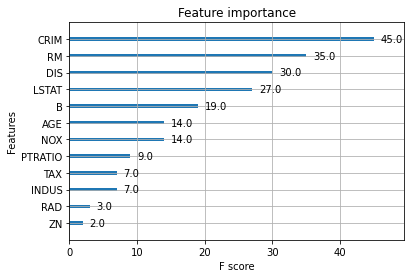

In [35]:
xgb.plot_importance(bst)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

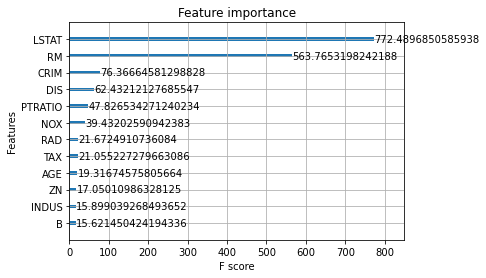

In [36]:
xgb.plot_importance(bst, importance_type='gain')

## 绘制树

+ `xgboost.plot_tree(booster, fmap='', num_trees=0, rankdir=None, ax=None, **kwargs)`
  + `num_trees`：指定要绘制的树的编号  
  ...
  
+ `xgboost.to_graphviz(booster, fmap='', num_trees=0, ..., **kwargs)`
  + `num_trees`：指定要绘制的树的编号

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

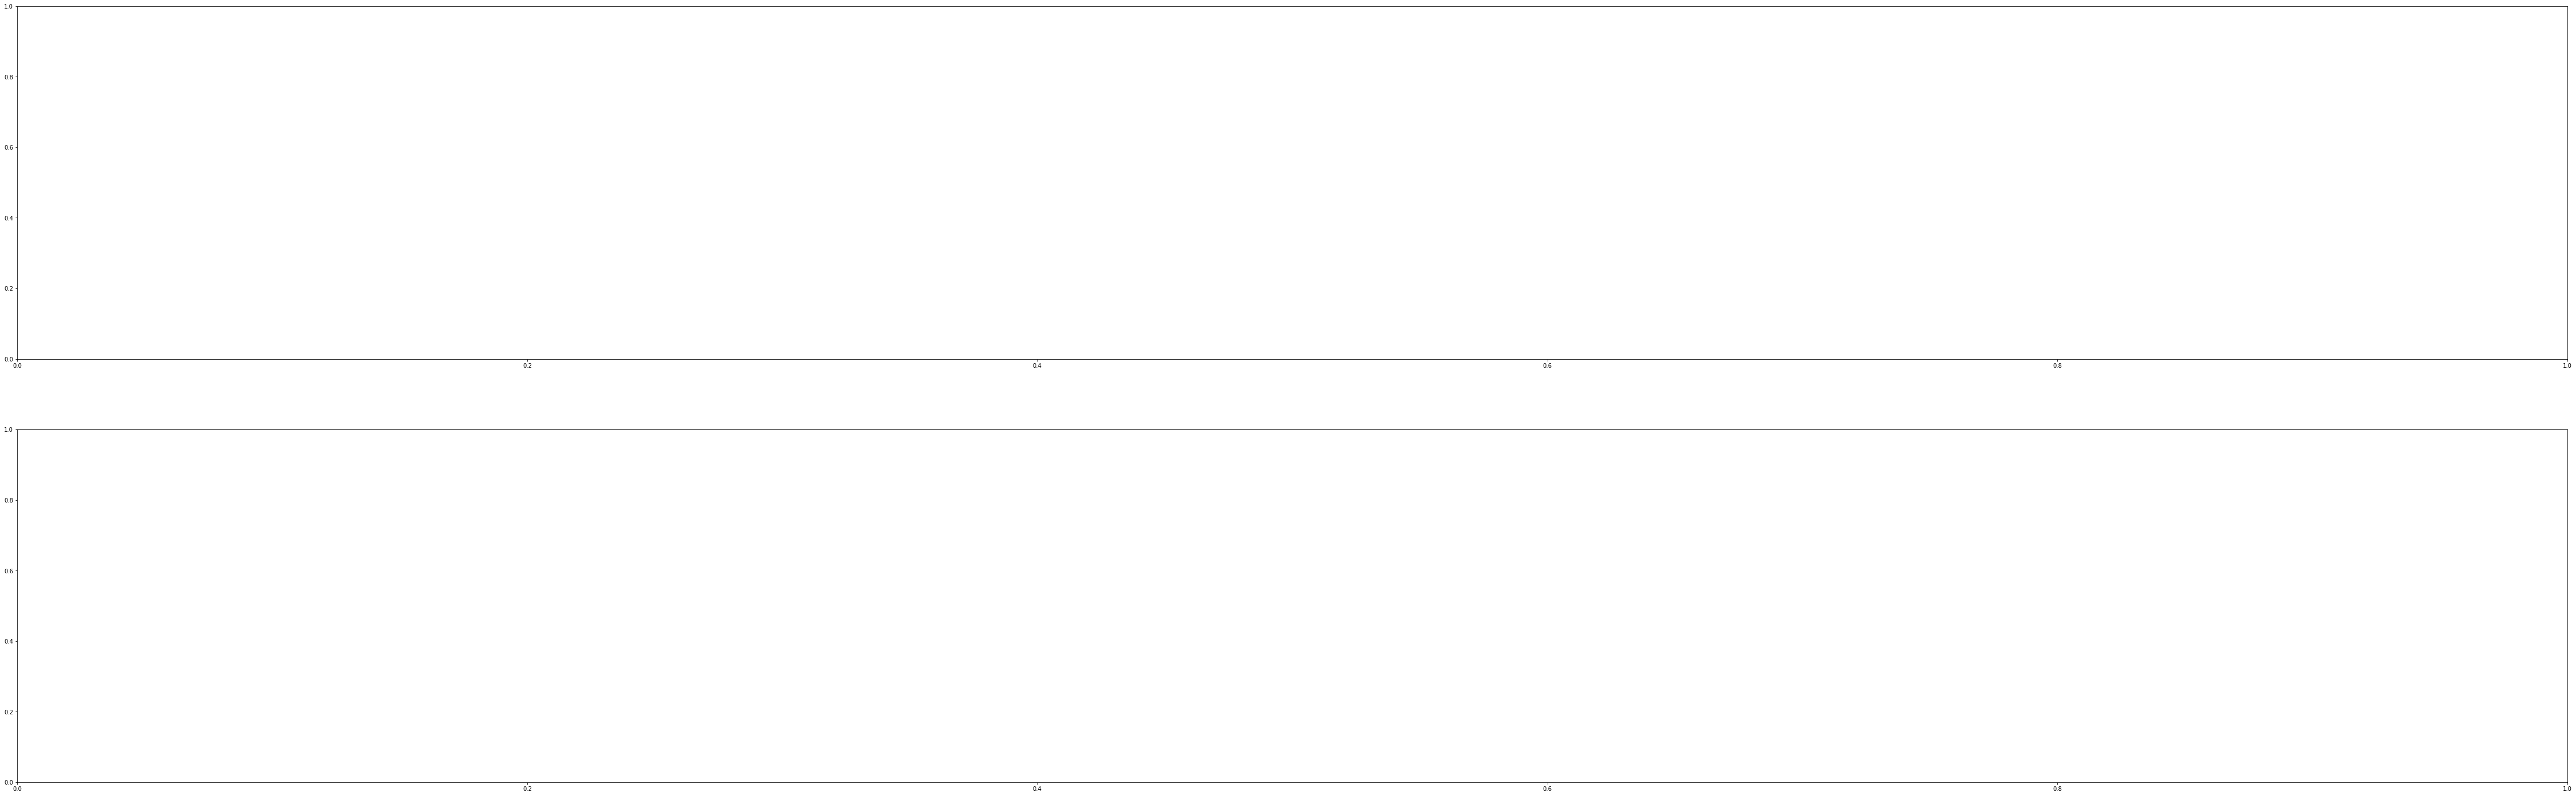

In [39]:
fig, axes = plt.subplots(2,1, figsize=(80,25))
xgb.plot_tree(booster=bst, num_trees=0, ax=axes[0])
xgb.plot_tree(booster=bst, num_trees=1, ax=axes[1])

## 模型保存

`Booster()`类有如下方法用于保存模型：

+ `dump_model()`：保存模型

+ `save_config()`：保存配置

+ `save_model()`：保存模型

+ `load_config()`：载入配置

+ `load_model()`：载入模型

## 交叉验证  

```python
xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, ...)
```

+ `params`：booster参数，字典
+ `dtrain`：训练数据
+ `num_boost_round`：boosting的数量
+ `nfold`：CV的折数，default=3
+ `stratified`：是否分层，default=False
+ `fold`: 分层对象
+ `obj`：**自定义目标函数**
+ `feval`/`custom_metric`：**自定义的metric函数**
+ `shuffle`：是否混洗数据，default=True
+ `metrics`: list of str，交叉验证时关注的指标
+ `verbose_eval`: 是否打印日志

默认返回值是一个dataframe，行数=树的个数`num_boost_round`，列数=`metrics`的长度x4，也就是每个指标会输出 4 个值：训练集误差均值，训练集方差，验证集误差均值，验证集方差。

In [35]:
# 这个params字段里配置的是 Booster 类的参数
params = {
    'booster':'gbtree',  #基分类器
    'objective': 'reg:squarederror', #目标函数
    'eta': 0.3,  #学习速率
    'gamma': 0,  #分咧的最小增益
    'max_depth': 6,  #树的最大深度
    'lambda': 1,  #L2正则项系数
    'alpha': 0,  # L1正则项系数
    'subsample': 1,  #boostrap是的采样比例
    'tree_method': 'auto',  # 树的生成方式
    'base_score': 0.5  # 生成第一棵树时的初始值
    ,'eval_metric': ['rmse'] # 在 验证集 上进行评估的指标，可以选择多个
    # ,'eval_metric': ['rmse','mae']
}

# booster的个数
num_round = 10

# 交叉验证的折数
n_fold = 5

In [39]:
history = xgb.cv(
    params=params, dtrain=dtrain, num_boost_round=num_round, 
    nfold=n_fold,
    # verbose_eval=True
)

In [40]:
history

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.442039,0.004656,1.447455,0.014810
1,1.105136,0.004679,1.117825,0.012260
2,0.881440,0.005020,0.902786,0.010442
3,0.736197,0.006476,0.765191,0.007523
4,0.644387,0.004202,0.680716,0.005571
5,0.588064,0.003668,0.632727,0.004570
6,0.548886,0.002412,0.599641,0.003880
7,0.522829,0.001408,0.579553,0.004447
8,0.502823,0.003235,0.563615,0.005322
9,0.486265,0.003206,0.551849,0.005587


+ 使用交叉验证来寻找最优的超参数`num_boost_round`  
这个不太一样，因为XGB的CV会返回每一轮的树的CV结果，所以只需要把`num_boost_round`  设置的足够大，然后在结果里找mean里较小的，或者误差下降不太明显处的`num_boost_round`  就可以了。

In [41]:
# 取150个
history = xgb.cv(params=params, dtrain=dtrain, num_boost_round=150, nfold=n_fold)

In [42]:
history.shape

(150, 4)

In [48]:
from plotly import graph_objects as go
import plotly.express as px

In [45]:
# 这里使用plotly绘图，绘图前需要将history从wide格式转成long格式

# 增加一列表示 num_round
history['num_round'] = np.arange(1,151)

#分别提取训练误差和测试误差
train_info = history.loc[:,['num_round','train-rmse-mean','train-rmse-std']]
test_info = history.loc[:,['num_round','test-rmse-mean','test-rmse-std']]

# 需要改名，否则会产生多余的null列
train_info.columns = ['num_round','rmse-mean','rmse-std']
test_info.columns = ['num_round','rmse-mean','rmse-std']

# 增加一列用户区分训练误差和测试误差
train_info['type'] = 'train'
test_info['type'] = 'test'

# 合并
history_info = pd.concat([train_info, test_info], axis=0)

In [50]:
history_info.head()

,num_round,rmse-mean,rmse-std,type
0,1,1.442039,0.004656,train
1,2,1.105136,0.004679,train
2,3,0.881440,0.005020,train
3,4,0.736197,0.006476,train
4,5,0.644387,0.004202,train


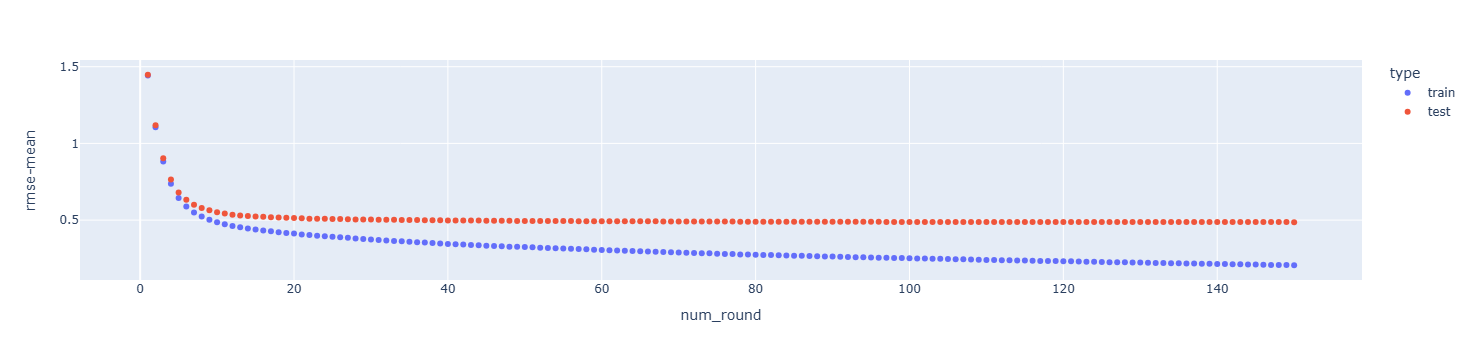

In [51]:
# 使用plotly绘制
px.scatter(data_frame=history_info, x='num_round',y='rmse-mean', color='type' )

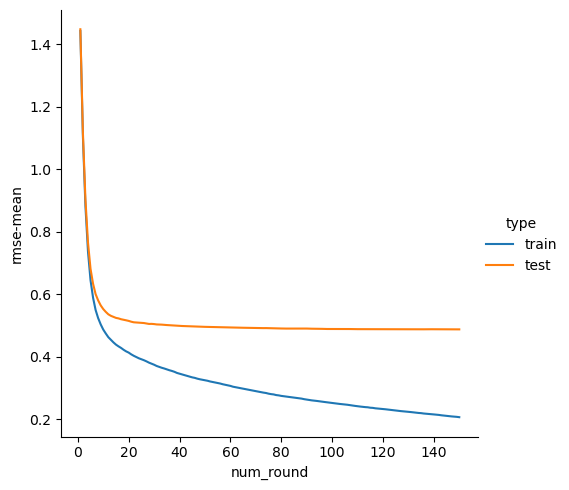

In [52]:
# 使用seaborn绘制
sns.relplot(data=history_info, x ='num_round', y='rmse-mean', hue='type', kind='line' )

从图中可以看出 num_round = 15 之后test-rmse就不太下降了，所以只需要选择 num_round = 15 即可

____________

# Sklearn接口

## XGBRegressor

`class xgboost.XGBRegressor(*, objective='reg:squarederror', **kwargs)`类：

初始化参数（基本和xgb接口差不多）：
+ booster
+ n_estimators
+ objective
+ max_depth
+ max_leaves
+ learning_rate
+ tree_method
+ gamma
+ reg_alpha
+ reg_lambda
+ base_score
+ eval_metric
+ subsample
+ sampling_method
+ min_child_weight
+ grow_policy
+ verbosity

常用属性：
+ coef_
+ intercept_
+ feature_importances_

常用方法：
+ `fit(X, y,...)`
+ `predict(X, ...)`
+ `score(X, y)`
+ `apply(X, ntree_limit=0, iteration_range=None)`
+ `evals_result()`
+ `save_model(fname)`
+ `load_model(fname)`


上面使用`xgboost.train`时的参数配置，这里复制过来好做对对比
```python
params = {
    'booster':'gbtree',  #基分类器
    'objective': 'reg:squarederror', #目标函数
    'eta': 0.3,  #学习速率
    'gamma': 0,  #分裂的最小增益
    'max_depth': 6,  #树的最大深度
    'lambda': 1,  #L2正则项系数
    'alpha': 0,  # L1正则项系数
    'subsample': 1,  #boostrap是的采样比例
    'tree': 'auto',  # 树的生成方式
    'base_score': 0.5,  # 生成第一棵树时的初始值
    'eval_metric': ['rmse','mae']  # 在 验证集 上进行评估的指标，可以选择多个
}  

# booster的个数
num_round = 10

# 用于训练时查看验证集上效果的 evals (list of pairs (DMatrix, string)) 
watch_list = [(dtrain, 'val_train'), (dtest, 'val_test')]
```

In [54]:
from xgboost import XGBRegressor as XGBR

In [82]:
# sklearn接口不能使用字典的形式配置参数
xgbr = XGBR(
    booster = 'gbtree',
    objective='reg:squarederror',
    n_estimators = 10, #相当于num_booster_round
    max_depth = 6,
    learning_rate = 0.3, # 学习速率
    tree_method = 'auto',
    gammar = 0,   # 分裂的最小增益
    reg_alpah= 0, # L1正则化参数
    reg_lambda= 1, # L2正则化参数
    subsample= 1,  # 列采样比例
    base_score= 0.5
)

xgbr.fit(X=Xtrain, y=ytrain)

[18:47:25] WARNING: D:\bld\xgboost-split_1667849704519\work\src\learner.cc:767: 
Parameters: { "gammar", "reg_alpah" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gammar=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [83]:
# 也可以传入验证集
xgbr = XGBR(
    booster = 'gbtree',
    objective='reg:squarederror',
    n_estimators = 10, #相当于num_booster_round
    max_depth = 6,
    learning_rate = 0.3, # 学习速率
    tree_method = 'auto',
    gammar = 0,   # 分裂的最小增益
    reg_alpah= 0, # L1正则化参数
    reg_lambda= 1, # L2正则化参数
    subsample= 1,  # 列采样比例
    base_score= 0.5,
    eval_metric=['mae','rmse']
)

xgbr.fit(X=Xtrain,y=ytrain, eval_set=[(Xtrain, ytrain)])

[18:47:34] WARNING: D:\bld\xgboost-split_1667849704519\work\src\learner.cc:767: 
Parameters: { "gammar", "reg_alpah" } are not used.

[0]	validation_0-mae:1.11335	validation_0-rmse:1.44435
[1]	validation_0-mae:0.81661	validation_0-rmse:1.10565
[2]	validation_0-mae:0.62720	validation_0-rmse:0.88097
[3]	validation_0-mae:0.51422	validation_0-rmse:0.73986
[4]	validation_0-mae:0.44274	validation_0-rmse:0.64561
[5]	validation_0-mae:0.40497	validation_0-rmse:0.59143
[6]	validation_0-mae:0.37861	validation_0-rmse:0.55445
[7]	validation_0-mae:0.36251	validation_0-rmse:0.52890
[8]	validation_0-mae:0.34939	validation_0-rmse:0.50881
[9]	validation_0-mae:0.33597	validation_0-rmse:0.48914


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=['mae', 'rmse'], feature_types=None, gamma=0, gammar=0,
             gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [64]:
xgbr.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': ['mae', 'rmse'],
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.3,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 10,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'auto',
 'validate_parameters': 1,
 'verbosity': None,
 'gammar': 0,
 'reg_alpah': 0}

In [65]:
xgbr.get_xgb_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'eval_metric': ['mae', 'rmse'],
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.3,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'auto',
 'validate_parameters': 1,
 'verbosity': None,
 'gammar': 0,
 'reg_alpah': 0}

In [76]:
xgbr.get_booster()

In [66]:
xgbr.get_num_boosting_rounds()

10

In [67]:
xgbr.feature_importances_

array([0.6052772 , 0.05918762, 0.04551701, 0.01303093, 0.01254526,
       0.15701506, 0.0529846 , 0.05444238], dtype=float32)

In [68]:
# 这里默认返回的是R^2，不是MSE，可使用shift + tab查看签名
xgbr.score(Xtest, ytest)

0.7852042271980363

In [73]:
y_predict = xgbr.predict(Xtrain)

In [74]:
from sklearn.metrics import r2_score

In [75]:
r2_score(y_true=ytrain, y_pred=y_predict)

0.8203088287809563

交叉验证效果

In [77]:
from sklearn.model_selection import cross_val_score

In [79]:
xgbr = XGBR(n_estimators=100)
cross_val_score(xgbr, Xtrain, ytrain, cv=5)

array([0.82623025, 0.82791877, 0.81990662, 0.82786391, 0.81353271])

In [73]:
# 查看sklearn中已有的指标
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [81]:
# 使用其他指标
cross_val_score(xgbr, Xtrain, ytrain, cv=5, scoring='neg_mean_squared_error')

array([-0.236234  , -0.23946451, -0.24153121, -0.21514895, -0.24522111])

## XGBClassifier

## XGBRanker

## XGBRFRegressor

## XGBRFClassifier

## 两类接口的比较

主要是比较验证集相关的参数设置。

XGB两套接口的参数里，关于验证集的几个参数作用让人比较疑惑：

1. `xgb.train()`中
   + `eval_metric`——验证集的指标名称，需要写在`param`的字典里，它只能传入自带的指标
   + `evals`，验证集，是 list of `(DMatrix, str)`的格式

   + `feval`，自定义的验证集指标计算函数

2. `xgb.XGBRegressor().fit()`方法里

   + `eval_metric`，指定验证集指标，和`xgb.train()`里不一样的是，它既能传入自带指标，又能传入自定义函数——**新版本里它改成类的初始化参数了**
   + `eval_set`，验证集，是 list of `(Xval, yval)`的格式

使用验证集的时候，`eval_metric`参数都是**可选的**，因为每个目标函数会有默认的验证指标，但是如果没有传入验证集，训练过程就不会打印在验证集上的结果。

不过有一点不同的是：
+ `xgb.train()`中，通过`evals`传入的验证集可以指定名称（也就是元组里第2个`str`字段），打印验证集结果的时候，会使用这个名称；
+ sklearn接口里，通过`eval_set`传入的验证集不能指定名称，只能使用默认的`{validation_num}`作为名称。

In [89]:
from sklearn.metrics import r2_score

def r2_score_xgb(y_pred, dtrain):
    """
    自定义的验证集评估函数，函数签名必须为: y_pred, DMatrix
    返回值必须为 (string, score)，str 是评估指标的名称，score是指标值
    """
    y_true = dtrain.get_label()
    score=r2_score(y_true, y_pred)
    return "R^2", score
#     return score

+ 使用原生接口

In [96]:
params = {
    'booster':'gbtree',
    'objective': 'reg:squarederror',
    'verbosity':1,
    # 在 验证集 上进行评估的指标，可以选择多个
    'eval_metric': ['rmse']
    # 'eval_metric': ['rmse','mae']
}
num_round = 10
watch_list = [(dtrain, 'val_train'), (dtest, 'val_test')]

bst = xgb.train(
    params=params, dtrain=dtrain, 
    num_boost_round=num_round,
    evals=watch_list,
    custom_metric=r2_score_xgb  # 使用了自定义指标
)

[0]	val_train-rmse:1.44435	val_train-R^2:-0.56673	val_test-rmse:1.44693	val_test-R^2:-0.57229
[1]	val_train-rmse:1.10565	val_train-R^2:0.08191	val_test-rmse:1.10772	val_test-R^2:0.07850
[2]	val_train-rmse:0.88097	val_train-R^2:0.41713	val_test-rmse:0.88730	val_test-R^2:0.40875
[3]	val_train-rmse:0.73986	val_train-R^2:0.58890	val_test-rmse:0.75214	val_test-R^2:0.57516
[4]	val_train-rmse:0.64561	val_train-R^2:0.68696	val_test-rmse:0.66511	val_test-R^2:0.66778
[5]	val_train-rmse:0.59143	val_train-R^2:0.73730	val_test-rmse:0.61825	val_test-R^2:0.71295
[6]	val_train-rmse:0.55445	val_train-R^2:0.76913	val_test-rmse:0.58601	val_test-R^2:0.74210
[7]	val_train-rmse:0.52890	val_train-R^2:0.78991	val_test-rmse:0.56520	val_test-R^2:0.76009
[8]	val_train-rmse:0.50881	val_train-R^2:0.80557	val_test-rmse:0.55051	val_test-R^2:0.77241
[9]	val_train-rmse:0.48914	val_train-R^2:0.82031	val_test-rmse:0.53480	val_test-R^2:0.78520


+ 使用sklearn接口

In [97]:
xgbr = XGBR(
    booster = 'gbtree',
    objective='reg:squarederror',
    n_estimators = 10, #相当于num_booster_round
    verbosity=1,
    eval_metric=['rmse']
    # eval_metric=['rmse', 'mae']
    # eval_metric=r2_score_xgb  # 自定义指标
)

# 训练时传入验证集
# xgbr.fit(X=Xtrain, y=ytrain)
xgbr.fit(
    X=Xtrain, y=ytrain,
    eval_set=[(Xtrain, ytrain), (Xtest, ytest)]
)

[0]	validation_0-rmse:1.44435	validation_1-rmse:1.44693
[1]	validation_0-rmse:1.10565	validation_1-rmse:1.10772
[2]	validation_0-rmse:0.88097	validation_1-rmse:0.88730
[3]	validation_0-rmse:0.73986	validation_1-rmse:0.75214
[4]	validation_0-rmse:0.64561	validation_1-rmse:0.66511
[5]	validation_0-rmse:0.59143	validation_1-rmse:0.61825
[6]	validation_0-rmse:0.55445	validation_1-rmse:0.58601
[7]	validation_0-rmse:0.52890	validation_1-rmse:0.56520
[8]	validation_0-rmse:0.50881	validation_1-rmse:0.55051
[9]	validation_0-rmse:0.48914	validation_1-rmse:0.53480


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=['rmse'], feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

# XGBoost的调参

|影响力|参数|
|:-:|:-:|
|⭐⭐⭐⭐⭐<br>几乎总是具有巨大影响力|num_boost_round（整体学习能力）<br>eta（整体学习速率）<br>|
|⭐⭐⭐⭐<br>大部分时候具有影响力|booster（整体学习能力）<br>colsample_by*（随机性）<br>gamma（结构风险 + 精剪枝）<br>lambda（结构风险 + 间接剪枝）<br> min_child_weight（精剪枝）|
|⭐⭐<br>可能有大影响力<br>大部分时候影响力不明显|max_depth（粗剪枝）<br>alpha（结构风险 + 精剪枝）<br>subsamples（随机性）<br>objective（整体学习能力）<br>scale_pos_weight（样本不均衡）|
|⭐<br>当数据量足够大时，几乎无影响|seed<br>base_score（初始化）<br>|


优先调整的参数  
+ `n_estimator`或者`num_boost_round`，一般在300以下
+ `gammar`，进行分支时的最小增益
+ `max_depth`，这个参数和上面的`gammar`通常选择一个进行调整就可以了
+ `colsample_bytree`，默认为1，列采样（每次生成树时随机抽样特征）的比例
+ `colsample_bylevel`，默认为1，每次生成**树的一层**时 随机抽样特征的比例
+ `colsample_bynode`，默认为1，每次生成**一个叶子节点**时 随机抽样特征的比例

通常不调整的参数  
+ 学习速率`eta`或者`learning_rate`，这个参数对于模型的收敛速度影响较大，但是通常**不调整这个**，即使调整，它的值也在$[0.01, 0.2]$之间变动
+ 采样比例`subsample`，默认为1，通常也不调整，只有在样本数据量非常大的时候才进行调整
+ 正则化参数 L1的`alpha`或者`reg_alpha`，L2的`lambda`或者`reg_lambda`，如果要调整，通常优先选择调整L2正则参数

观察n_estimator的学习曲线

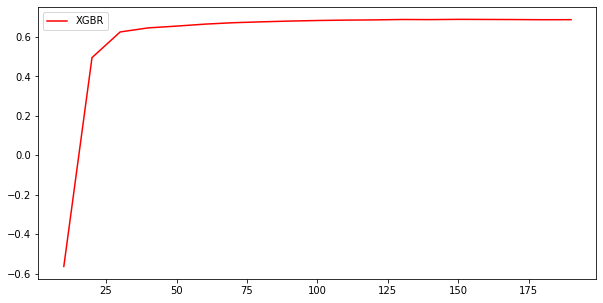

In [89]:
n_estimator_range = range(10, 200, 10)
score = []
for n_estimator in n_estimator_range:
    xgbr = XGBR(n_estimators=n_estimator, silent=True)
    result = cross_val_score(xgbr, X, y, cv=5).mean()
    score.append(result)
    
plt.figure(figsize=(10,5))
plt.plot(n_estimator_range, score, c='red', label='XGBR')
plt.legend()

In [90]:
print(n_estimator_range[score.index(max(score))], max(score))

150 0.6885265739694534


重新绘制带方差和偏差的学习曲线

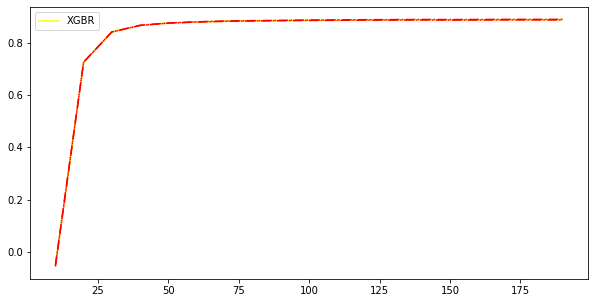

In [91]:
n_estimator_range = range(10, 200, 10)
cv = KFold(n_splits=5, shuffle=True, random_state=29)
score = []
var = []
ge = []

for n_estimator in n_estimator_range:
    xgbr = XGBR(n_estimators=n_estimator, silent=True)
    cv_result = cross_val_score(xgbr, X, y, cv=cv)
    score.append(cv_result.mean())
    var.append(cv_result.var())
    ge.append((1 - cv_result.mean())**2 + cv_result.var())

score = np.array(score)
var = np.array(var)

plt.figure(figsize=(10,5))
plt.plot(n_estimator_range, score, c='yellow', label='XGBR')
# 添加方差线
plt.plot(n_estimator_range, score-var, c='red', linestyle='-.')
plt.plot(n_estimator_range, score+var, c='red', linestyle='-.')
plt.legend()

调整增益参数$\gamma$
需要使用xgboost本身库里的xgboost.cv来查看效果

In [92]:
import xgboost as XGB

from time import time
from datetime import datetime

首先练习使用xgboost.cv()函数

In [93]:
data = XGB.DMatrix(X,y)
param = {'silent':True, 'obj':'reg:linear', 'gamma':0}
num_round = 180
n_fold = 5

In [94]:
time0 = time()
cv_result = XGB.cv(params=param, dtrain=data, num_boost_round=num_round, nfold=n_fold)
time_diff = time() - time0
print("running time : " + datetime.fromtimestamp(time_diff).strftime('%M:%S:%f'))

running time : 00:00:679215


In [95]:
type(cv_result)

pandas.core.frame.DataFrame

In [96]:
cv_result.__class__

pandas.core.frame.DataFrame

In [97]:
cv_result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,17.105577,0.129117,17.163215,0.584297
1,12.337972,0.097556,12.519736,0.473458
2,8.994071,0.065756,9.404534,0.472310
3,6.629480,0.050323,7.250335,0.500342
4,4.954407,0.033209,5.920812,0.591874
...,...,...,...,...
175,0.001299,0.000289,3.669898,0.857676
176,0.001285,0.000261,3.669897,0.857677
177,0.001275,0.000239,3.669903,0.857669
178,0.001263,0.000217,3.669901,0.857672


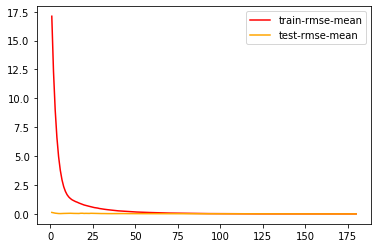

In [98]:
plt.plot(range(1, 181), cv_result.iloc[:,0], c='red', label="train-rmse-mean")
plt.plot(range(1,181), cv_result.iloc[:,1], c='orange', label='test-rmse-mean')
plt.legend()

使用xgboost.cv来调整$\gamma$

In [99]:
num_round = 180
n_fold = 5
param1 = {'silent':True, 'obj':'reg:linear', 'gamma':0}
param2 = {'silent':True, 'obj':'reg:linear', 'gamma':20}

cv_result1 = XGB.cv(params=param1, dtrain=data, num_boost_round=num_round, nfold=n_fold)
cv_result2 = XGB.cv(params=param2, dtrain=data, num_boost_round=num_round, nfold=n_fold)

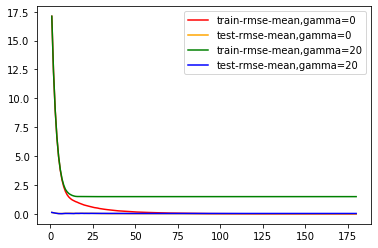

In [100]:
plt.plot(range(1, 181),cv_result1.iloc[:,0], c='red', label="train-rmse-mean,gamma=0")
plt.plot(range(1,181), cv_result1.iloc[:,1], c='orange', label='test-rmse-mean,gamma=0')
plt.plot(range(1,181), cv_result2.iloc[:,0], c='green', label="train-rmse-mean,gamma=20")
plt.plot(range(1,181), cv_result2.iloc[:,1], c='blue', label='test-rmse-mean,gamma=20')
plt.legend()

______

# 样本不均衡问题

------

# 对比随机森林和线性回归

In [89]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold

In [101]:
# 线性回归
lr = LinearRegression()
lr.fit(Xtrain,ytrain)
lr.score(Xtest,ytest)

0.7769540740816125

In [102]:
# 随机森林
rf = RFR(n_estimators=20)
rf.fit(Xtrain,ytrain)
rf.score(Xtest,ytest)

0.8398599894467208

In [103]:
# XGBoost
xgbr = XGBR(
    booster = 'gbtree',
    objective='reg:squarederror',
    n_estimators = 10, #相当于num_booster_round
    max_depth = 6,
    learning_rate = 0.3, # 学习速率
    tree_method = 'auto',
    gammar = 0,
    reg_alpah= 0, # L1正则化参数
    reg_lambda= 1, # L2正则化参数
    subsample= 1,
    base_score= 0.5
)
xgbr.fit(X=Xtrain,y=ytrain)
xgbr.score(Xtest, ytest)

0.841814503167488

In [107]:
- cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')

array([12.46030057, 26.04862111, 33.07413798, 80.76237112, 33.31360656])

In [106]:
- cross_val_score(rf,X,y,cv=5, scoring='neg_mean_squared_error')

array([ 8.01978039, 15.5468948 , 18.35381386, 43.13013738, 18.37307847])

In [108]:
- cross_val_score(xgbr,X,y,cv=5, scoring='neg_mean_squared_error')

array([ 8.5341622 , 16.5285442 , 20.92416823, 46.39984535, 17.47468213])